In [1]:
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())  # Should return True on M1/M2/M3

import torchvision
print(torchvision.__version__)

2.7.1
True
0.22.1


In [2]:
import coremltools
print(coremltools.__version__)

Torch version 2.7.1 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.


8.3.0


In [3]:
from torchvision import transforms

# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder('../Datasets/relabeled/train', transform=train_transform)
val_dataset = ImageFolder('../Datasets/relabeled/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

Number of training samples: 6612
Number of test samples: 1656


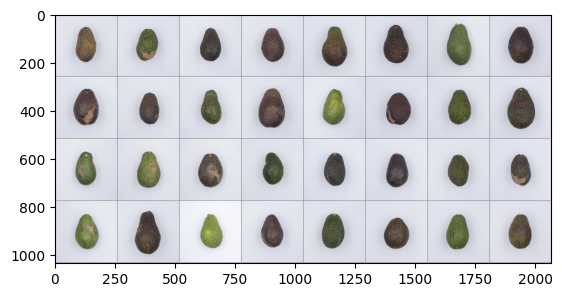

Labels: tensor([1, 0, 2, 2, 1, 1, 0, 1, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 2, 2, 0, 1,
        0, 1, 0, 2, 0, 1, 0, 0])


In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(val_dataset)}")

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(make_grid(images))
print('Labels:', labels)

In [ ]:
import torch.nn as nn
import timm

num_classes = len(train_dataset.classes)  # Your dataset’s class count

model = timm.create_model('fastvit_sa12', pretrained=True, exportable=True, num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

/opt/homebrew/Caskroom/miniconda/base/envs/fastvit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()

In [9]:
def inverse_normalize(tensor):
    """Inverse normalize a tensor for visualization."""
    m = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    s = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * s + m  # Unnormalize
    tensor = tensor.clamp(0, 1)   # Ensure pixel values are in [0, 1]
    return tensor

Epoch 1/10, Train Loss: 0.6431, Train Acc: 70.08%, Val Loss: 0.0099, Val Acc: 71.88%


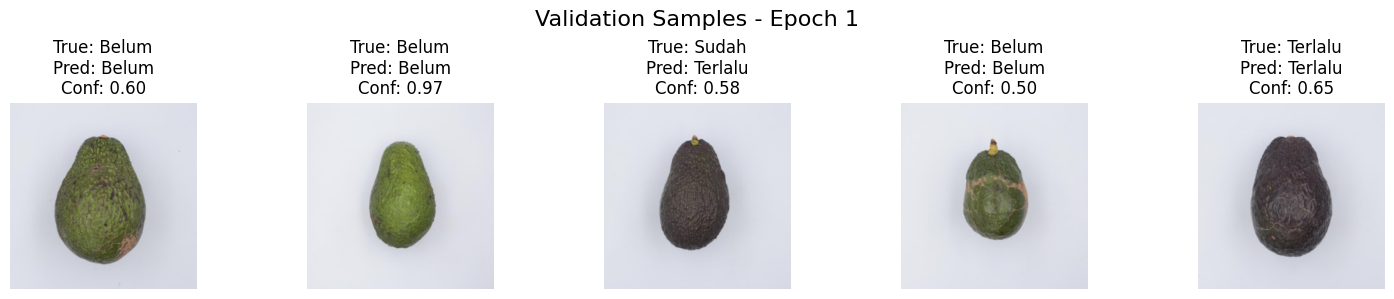

Epoch 2/10, Train Loss: 0.4938, Train Acc: 78.22%, Val Loss: 0.0072, Val Acc: 84.38%


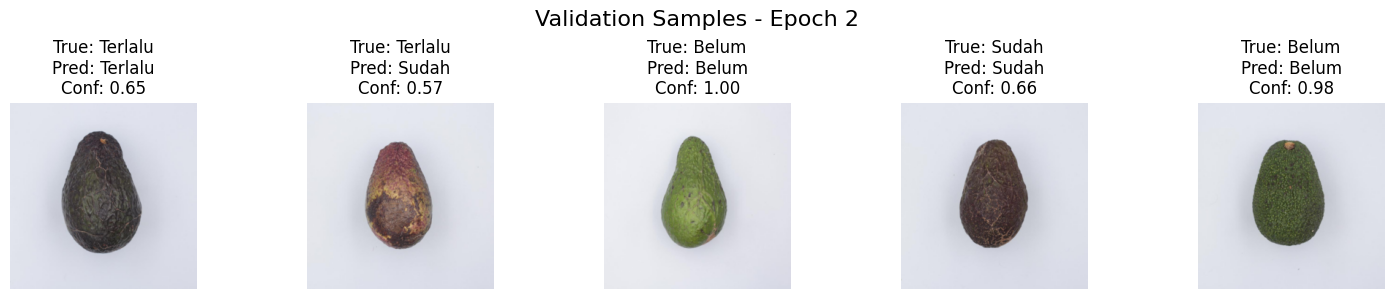

Epoch 3/10, Train Loss: 0.4744, Train Acc: 79.52%, Val Loss: 0.0073, Val Acc: 90.62%


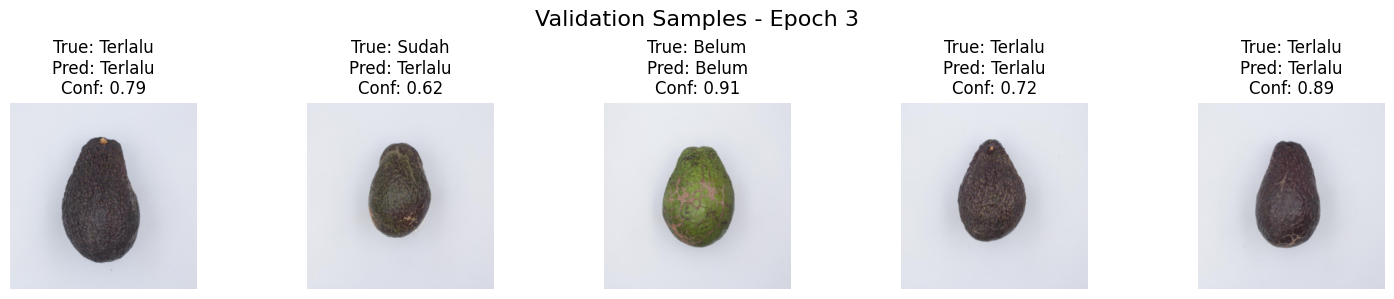

Epoch 4/10, Train Loss: 0.4636, Train Acc: 79.99%, Val Loss: 0.0054, Val Acc: 84.38%


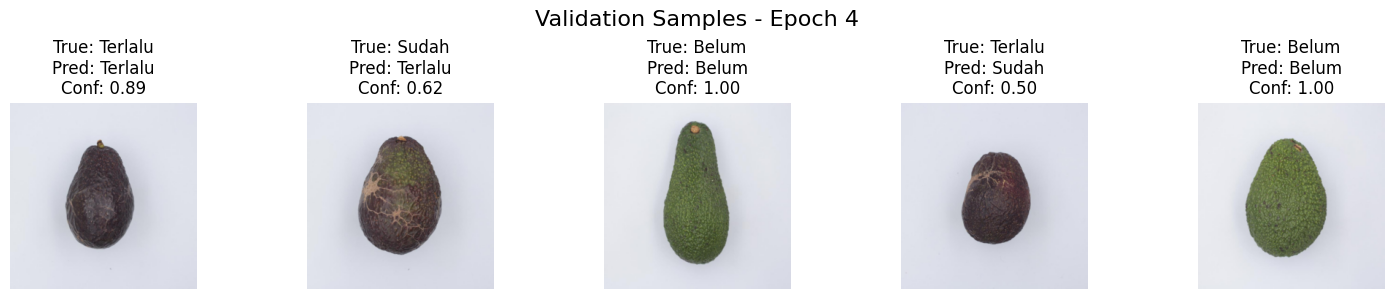

Epoch 5/10, Train Loss: 0.4540, Train Acc: 80.23%, Val Loss: 0.0065, Val Acc: 90.62%


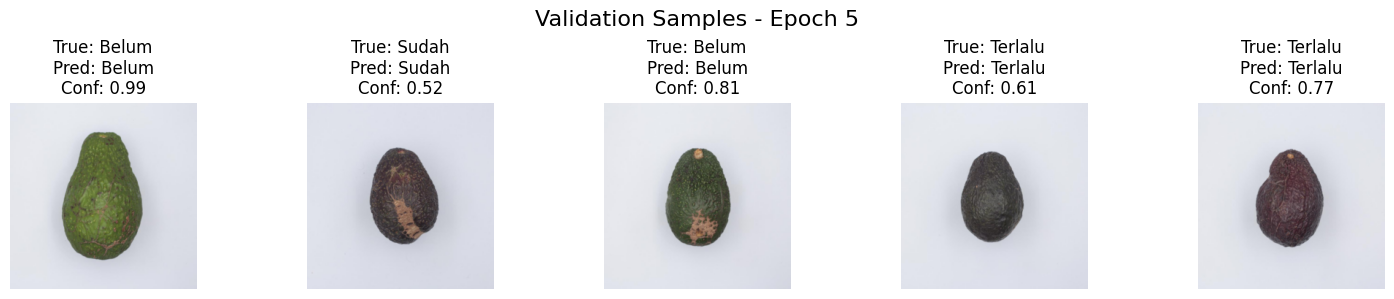

Epoch 6/10, Train Loss: 0.4345, Train Acc: 81.23%, Val Loss: 0.0098, Val Acc: 78.12%


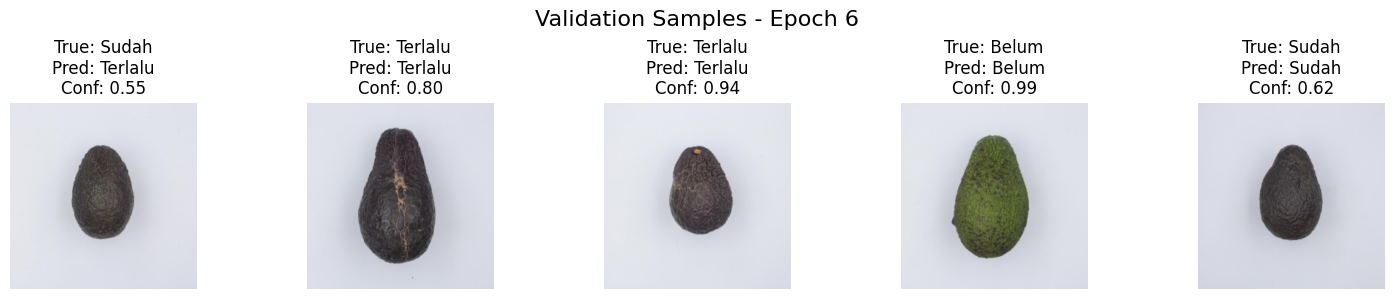

Epoch 7/10, Train Loss: 0.4354, Train Acc: 81.34%, Val Loss: 0.0068, Val Acc: 87.50%


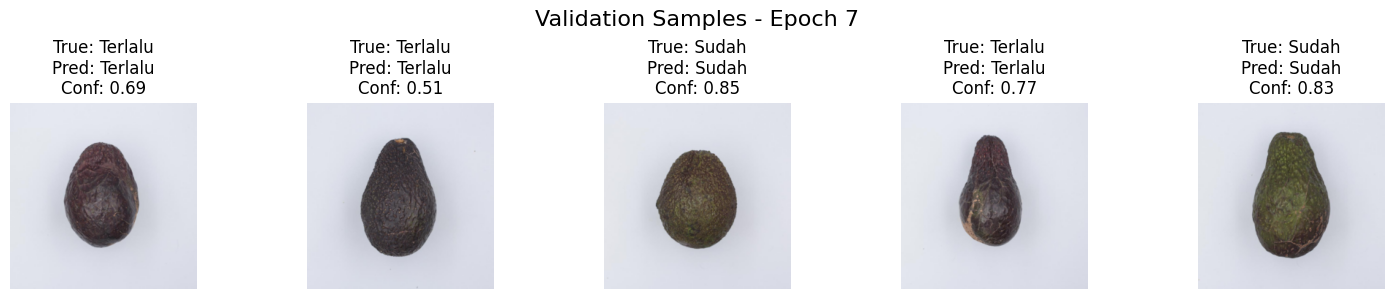

Epoch 8/10, Train Loss: 0.4280, Train Acc: 81.05%, Val Loss: 0.0068, Val Acc: 93.75%


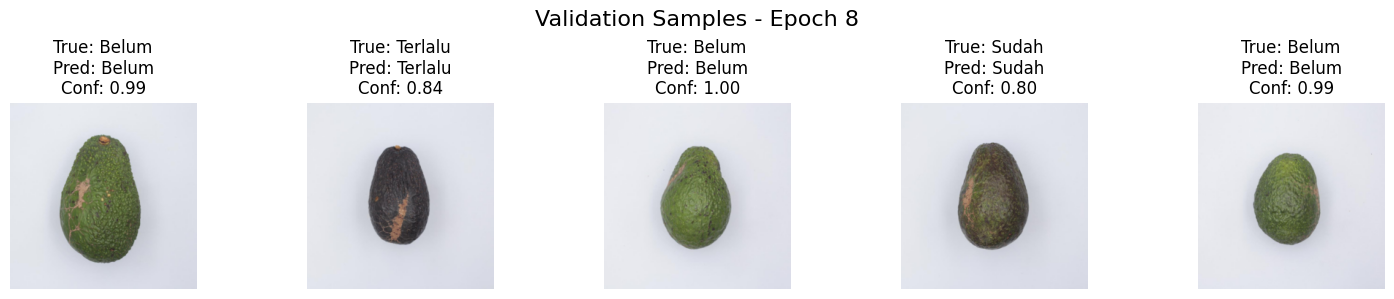

Epoch 9/10, Train Loss: 0.4240, Train Acc: 81.73%, Val Loss: 0.0082, Val Acc: 81.25%


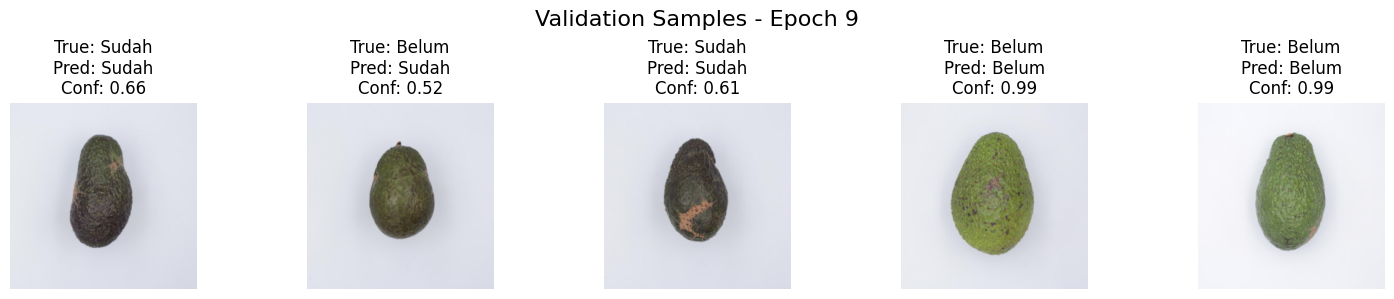

Epoch 10/10, Train Loss: 0.4251, Train Acc: 82.11%, Val Loss: 0.0074, Val Acc: 84.38%


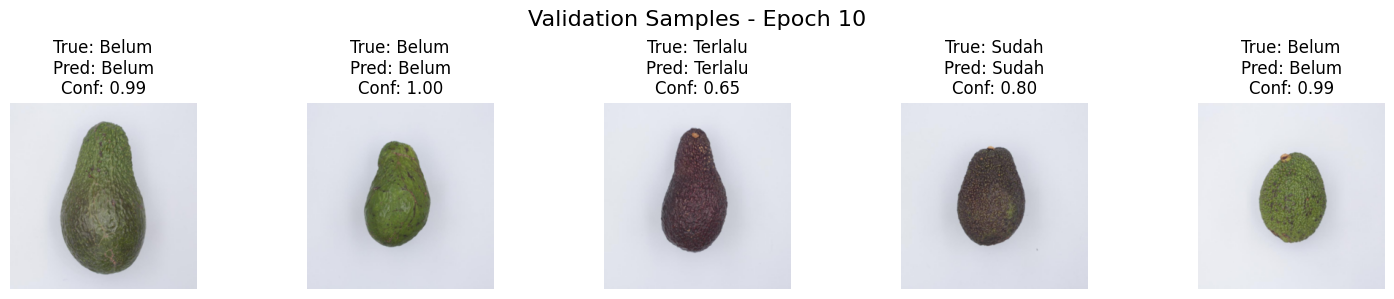

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_model(model, val_loader, criterion, device, num_samples=10):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    samples_collected = 0
    sample_data = []  # Store (image, true_label, pred_label, confidence)
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probabilities, dim=1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect samples for visualization
            if samples_collected < num_samples:
                for i in range(inputs.size(0)):
                    if samples_collected < num_samples:
                        sample_data.append((
                            inputs[i].cpu(),  # Image tensor
                            labels[i].cpu().item(),  # True label
                            predicted[i].cpu().item(),  # Predicted label
                            max_probs[i].cpu().item()  # Confidence
                        ))
                        samples_collected += 1
                    else:
                        break
            if samples_collected >= num_samples:
                break
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc, sample_data

def plot_samples(sample_data, class_names, epoch):
    """Plot 5 validation samples with true and predicted labels."""
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f"Validation Samples - Epoch {epoch + 1}", fontsize=16)
    
    for i, (img, true_label, pred_label, confidence) in enumerate(sample_data):
        img = inverse_normalize(img)  # Unnormalize for visualization
        if img.dim() == 4:  # Handle potential 4D tensor [1, C, H, W]
            img = img.squeeze(0)  # Remove batch dimension
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC for Matplotlib
        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_accuracy(train_accs, val_accs):
    """Plot training and validation accuracy over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training loop
num_epochs = 20
best_val_loss = float("-inf")
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, sample_data = validate_model(model, val_loader, criterion, device, num_samples=5)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    plot_samples(sample_data, train_dataset.classes, epoch)

    if val_loss > best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'fastvit_5c_finetuned.pth')
        
    scheduler.step()

In [13]:
val_loss, val_acc, _ = validate_model(model, val_loader, criterion, device)
print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

Final Validation Loss: 0.0078, Accuracy: 81.25%


In [14]:
torch.save(model.state_dict(), 'fastvit_fd_finetuned.pth')

In [18]:
import coremltools as ct

model.eval()

example_input = torch.rand(1, 3, 256, 256).to(device)
traced_model = torch.jit.trace(model, example_input)
coreml_model = ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="input", shape=example_input.shape)],
    classifier_config=ct.ClassifierConfig(train_dataset.classes)
)
coreml_model.save("FastViT_fulldata_Finetuned.mlpackage")

When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_target' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://apple.github.io/coremltools/docs-guides/source/target-conversion-formats.html
Running MIL default pipeline:   0%|          | 0/89 [00:00<?, ? passes/s]/opt/homebrew/Caskroom/miniconda/base/envs/fastvit/lib/python3.9/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '1525', of the source model, has been renamed to 'var_1525' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 216.90 passes/s]
